## Step 3: Sliding Window and Tests Implementation

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

### Test Images Read

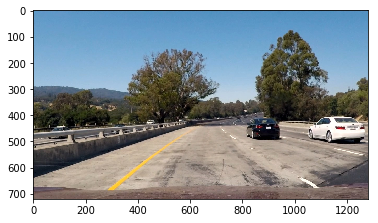

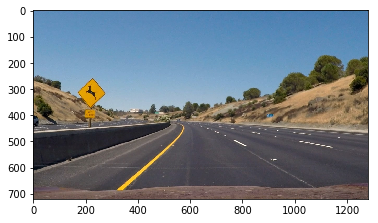

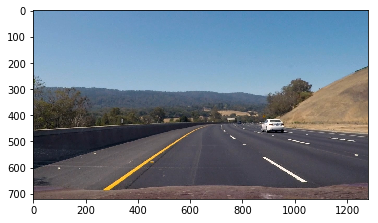

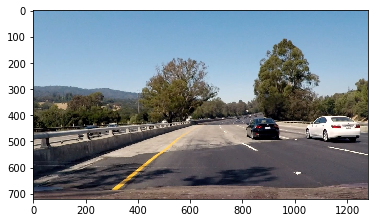

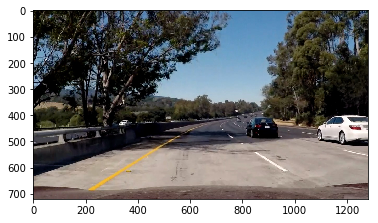

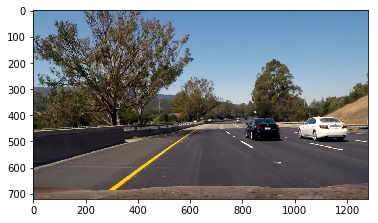

In [2]:
test_image_names = glob.glob('./test_images/test*.jpg')

test_images = []

#read images from filenames and convert to RGB from BGR
for fname in test_image_names:
    test_images.append(cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB))
    
for im in test_images:
    fig=plt.figure()
    plt.imshow(im)

### Trained Classifier Loading

In [3]:
training_parameters = open('training_parameters.p', 'rb') 
training_parameters = pickle.load(training_parameters)
svc = training_parameters['svc'] 
feature_scaler = training_parameters['feature_scaler']
orient = training_parameters['orient'] 
pix_per_cell = training_parameters['pix_per_cell']
cell_per_block = training_parameters['cell_per_block'] 
color_space = training_parameters['color_space']
hog_channel = training_parameters['hog_channel'] 
hist = training_parameters['hist']
spat = training_parameters['spat']

In [4]:
print('Orientation: ', orient)
print('Pixels per Cell: ', pix_per_cell)
print('Cells per Block: ', cell_per_block)
print('Color Space: ', color_space)
print('Hog Channel: ', hog_channel)
print('Histogram Features: ', hist)
print('Spatial Features: ', spat)

Orientation:  12
Pixels per Cell:  8
Cells per Block:  2
Color Space:  YCrCb
Hog Channel:  ALL
Histogram Features:  True
Spatial Features:  True


### Helper Functions

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), cspace='RGB'):
    if cspace=='gray':
        hist_features = np.histogram(img[:,:], bins=nbins, range=bins_range)
    else:
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
#Explore transform_sqrt later

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [8]:
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        return np.copy(img)

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

In [10]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [134]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if ((np.max(nonzerox) - np.min(nonzerox)) > 40) and ((np.max(nonzeroy) - np.min(nonzeroy)) > 40):
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [12]:
def find_centroids(labels):
    centroids = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        y = np.int(np.min(nonzeroy)+(np.max(nonzeroy)-np.min(nonzeroy))/2)
        x = np.int(np.min(nonzerox)+(np.max(nonzerox)-np.min(nonzerox))/2)
        centroids.append((y,x))
    return centroids

In [13]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, color_space,
              pix_per_cell, cell_per_block, hog_channel ='ALL', 
              hist = False, spat = False):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    
    ctrans_tosearch = ((ctrans_tosearch) / 255.)
    
    hot_windows = []
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 0:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel == 1:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel == 2:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            img_features = []
            # Extract HOG for this patch
            if hog_channel == 0:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1))
            elif hog_channel == 1:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat2))
            elif hog_channel == 2:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat3))
            else:  
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            img_features.append(hog_features)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spat == True:
                spatial_size = (32,32)
                spatial_features = bin_spatial(subimg, size=spatial_size)
                img_features.append(spatial_features)

            if hist == True:
                hist_bins = 64
                hist_range = (0,256)
                hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range, cspace=color_space)
                img_features.append(hist_features)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(img_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#     plt.figure()
#     plt.plot(np.concatenate(img_features))
#     plt.figure()
#     plt.plot(np.matrix.transpose(test_features))
    return draw_img, hot_windows

In [14]:
def find_cars_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, color_space,
              pix_per_cell, cell_per_block, hog_channel ='ALL', 
              hist = False, spat = False):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    
    ctrans_tosearch = ((ctrans_tosearch) / 255.)
    
    hot_windows = []
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 0:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel == 1:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel == 2:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            img_features = []
            # Extract HOG for this patch
            if hog_channel == 0:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1))
            elif hog_channel == 1:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat2))
            elif hog_channel == 2:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat3))
            else:  
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            img_features.append(hog_features)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spat == True:
                spatial_size = (32,32)
                spatial_features = bin_spatial(subimg, size=spatial_size)
                img_features.append(spatial_features)

            if hist == True:
                hist_bins = 64
                hist_range = (0,256)
                hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range, cspace=color_space)
                img_features.append(hist_features)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(img_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return hot_windows

### Images Test

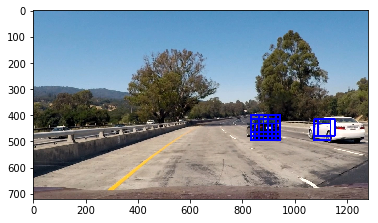

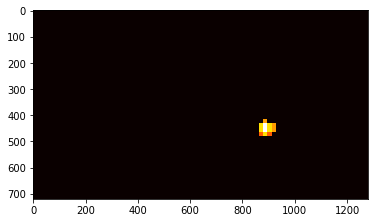

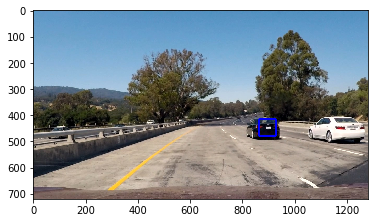

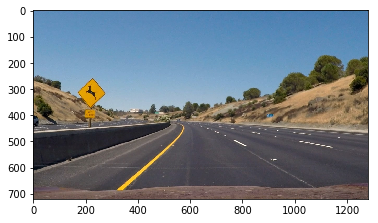

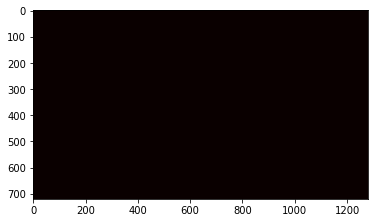

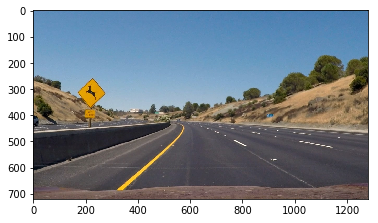

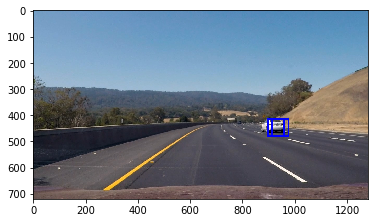

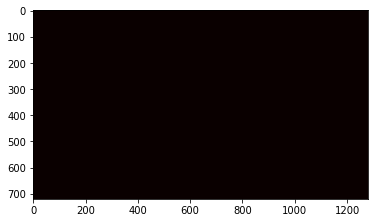

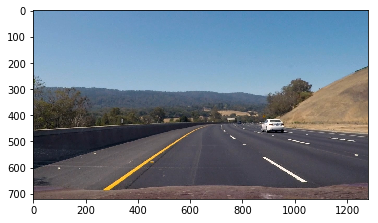

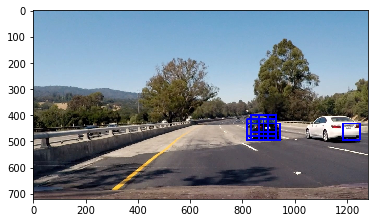

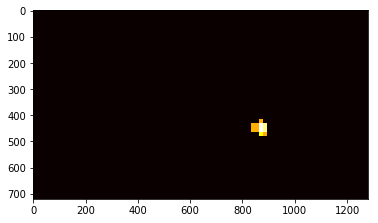

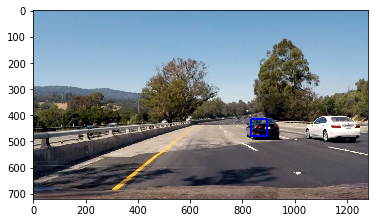

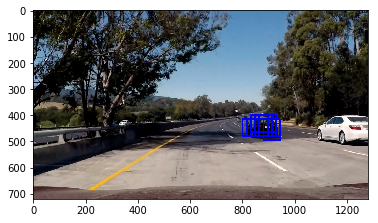

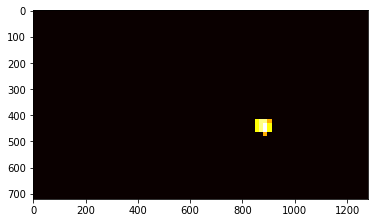

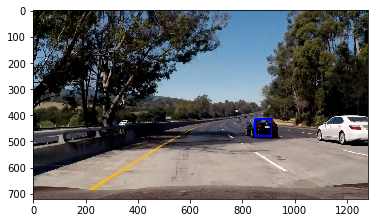

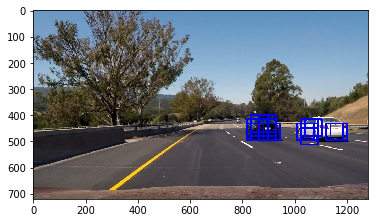

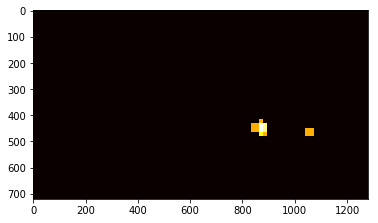

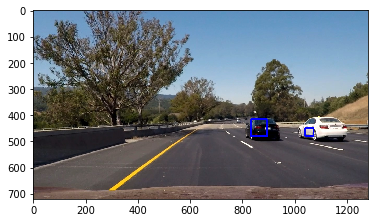

In [15]:
ystart = 400
ystop = 656
scale = 1
boxes_set = []
for img in test_images:
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, feature_scaler, orient, color_space, 
                               pix_per_cell, cell_per_block, hog_channel = hog_channel, hist = hist, spat = spat)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heat,boxes)
    heatmap = np.clip(heatmap, 0, 255)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.figure()
    plt.imshow(out_img)
    plt.figure()
    plt.imshow(heatmap, cmap='hot')
    plt.figure()
    plt.imshow(draw_img)

### Helper function for Video Processing

In [16]:
class Boxes():
    def __init__(self):
        # store recent boxes
        self.recent_boxes = []
        self.recent_centroids = []

In [142]:
def video_find_cars(img):
    ystart = 400
    ystop = 656
    scale = 1.5
    boxes = find_cars_boxes(img, ystart, ystop, scale, svc, feature_scaler, orient, color_space, 
                               pix_per_cell, cell_per_block, hog_channel = hog_channel, hist = hist, spat = spat)
    
    scale = 0.75
    more_boxes = find_cars_boxes(img, ystart, ystop, scale, svc, feature_scaler, orient, color_space, 
                               pix_per_cell, cell_per_block, hog_channel = hog_channel, hist = hist, spat = spat)
    
    track_boxes = []
    if len(B.recent_centroids)>0:
        for centroids in B.recent_centroids:
            if len(centroids)>0:
                for centr in centroids:
                    box = ((centr[1]-127, np.maximum(400,centr[0]-127)), (centr[1]+128, centr[0]+128))
                    track_boxes.append(box)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_recent_boxes = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_current_boxes = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_recent_labels = np.zeros_like(img[:,:,0]).astype(np.float)
    
    #heat from recent previous detections
    for b in B.recent_boxes:
        heat_recent_boxes = add_heat(heat_recent_boxes,b)
    heat_recent_boxes = np.clip(heat_recent_boxes, 0, 255)
    heat_recent_boxes = apply_threshold(heat_recent_boxes, np.int(len(B.recent_boxes)*5))
#     labels1 = label(heat_recent_boxes)
#     draw_img1 = draw_labeled_bboxes(np.copy(img), labels1)
    
    #heat from current detection
    heat_current_boxes = add_heat(heat_current_boxes,np.concatenate((boxes,more_boxes), axis = 0))
    heat_current_boxes = np.clip(heat_current_boxes, 0, 255)
    heat_current_boxes = apply_threshold(heat_current_boxes, 5)
#     labels2 = label(heat_current_boxes)
#     draw_img2 = draw_labeled_bboxes(np.copy(img), labels2)
    
    #heat from recent labels
    heat_recent_labels = add_heat(heat_recent_labels,track_boxes)
    heat_recent_labels = apply_threshold(heat_recent_labels, 2)
#     labels3 = label(heat_recent_labels)
#     draw_img3 = draw_labeled_bboxes(np.copy(img), labels3)
    
    heat = heat_recent_boxes + heat_current_boxes + heat_recent_labels
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heatmap, 5+np.int(len(B.recent_boxes)*3))
    labels = label(heatmap)
    
    if len(B.recent_boxes) > 10:
        B.recent_boxes.pop(0)
    B.recent_boxes.append(boxes) 
    
    if labels[1]>0:
        if len(B.recent_centroids) > 2:
            B.recent_centroids.pop(0)
        B.recent_centroids.append(find_centroids(labels))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Videos Test

In [ ]:
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")

B=Boxes()

road_clip = clip1.fl_image(video_find_cars) #NOTE: this function expects color images!!
%time road_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:08<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 8s


In [ ]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

B=Boxes()

road_clip = clip1.fl_image(video_find_cars) #NOTE: this function expects color images!!
%time road_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 32%|████████████▌                          | 407/1261 [12:25<25:40,  1.80s/it]